## **WEEK 1 CHALLENGE :**     *Stock Market Analysis*
* In this task, we shall analyze the stock price movement of 5 large-cap US companies : `APPLE`, `MICROSOFT`, `AMAZON`, `TESLA`, and `GOOGLE`.
* We will observe the changes in each stock's return values every day within a recent timespan of 10 years.
* The following quantities will be additionally calculated, tabulated and compared :
| Quantity | Definition |
| -------- | ---------- |
| Daily Return | The % change in the closing price compared to the previous day. |
| $7$-day Moving Average | The average closing price over the span of the last week |
| $30$-day Moving Average | The average closing price over the span of the last month. |
| $30$-day Rolling Volatilty | The standard deviation of the closing price over the span of the last month. |
* To conclude, we will answer two key questions:
    1. *Which stock had the **highest average return** over the 10-year period?*
    2. *Which stock had the **most volatile month**, and when?*

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

sns.set(style="darkgrid", context="talk", palette="Set2")

### **STEP 1 :** *Importing Data*
* We define the function ```load_stock_data```, which does the following tasks :-
    1. Loads the stocks data of our companies of interest, from the corresponding CSV files.
    2. Creates the dataframe *df_raw*, and *multiindexes* it into an *outer index* ```Ticker``` and *inner index* ```Dates```.
    3. Sorts *df_raw* on the basis of both the indices.

In [2]:
def load_stock_data (stock_dir, tickers) :
    stock_data = {}

    for ticker in tickers:
        file_path = os.path.join(stock_dir, f'{ticker}.txt')
        df = pd.read_csv(file_path)
        df['Ticker'] = ticker.lower()              # Add ticker info as a column
        df['Date'] = pd.to_datetime(df['Date'])    # Ensure 'Date' is datetime
        stock_data[ticker] = df

    df_raw = pd.concat(stock_data.values())        # Combine all dataframes

    # Set multi-index and sort for efficient access
    df_raw.set_index(['Ticker', 'Date'], inplace=True)
    df_raw.sort_index(inplace=True)

    return df_raw

stock_dir = 'data'
tickers = ['aapl.us', 'msft.us', 'amzn.us', 'tsla.us', 'googl.us']

df_raw = load_stock_data (stock_dir, tickers)

df_raw.head()

Open     High      Low    Close    Volume  OpenInt
Ticker  Date                                                             
aapl.us 1984-09-07  0.42388  0.42902  0.41874  0.42388  23220030        0
        1984-09-10  0.42388  0.42516  0.41366  0.42134  18022532        0
        1984-09-11  0.42516  0.43668  0.42516  0.42902  42498199        0
        1984-09-12  0.42902  0.43157  0.41618  0.41618  37125801        0
        1984-09-13  0.43927  0.44052  0.43927  0.43927  57822062        0

In [3]:
df_raw.tail()

Open    High     Low   Close   Volume  OpenInt
Ticker  Date                                                        
tsla.us 2017-11-06  307.00  307.50  299.01  302.78  6482486        0
        2017-11-07  301.02  306.50  300.03  306.05  5286320        0
        2017-11-08  305.50  306.89  301.30  304.31  4725510        0
        2017-11-09  302.50  304.46  296.30  302.99  5440335        0
        2017-11-10  302.50  308.36  301.85  302.99  4621912        0

### **STEP 2 :** *Cleaning Data*
* We define the following functions :-
    1. ```filter_stock_data``` to *filter in* the stocks data only from the last $10$ years, creating the dataframe *df_filtered*.
    2. ```find_missing_dates``` to detect all the *dates with missing stocks data* for any of the tickers.
    3. ```pad_stocks_data``` to *forward fill* all the missing entries to ensure continuity, creating the dataframe *df_clean*.

In [4]:
def filter_stocks_data (df_raw, years_back = 10) :
    # Determine date range
    end_date = df_raw.index.get_level_values('Date').max()
    start_date = end_date - pd.DateOffset(years=years_back)

    # Filter data within the date range
    df_filtered = df_raw.loc[ (start_date <= df_raw.index.get_level_values('Date')) & (df_raw.index.get_level_values('Date') <= end_date)].copy()

    # Generate all business days within the range
    all_dates = pd.date_range(start=start_date, end=end_date, freq='B')

    return df_filtered , all_dates

df_filtered , all_dates = filter_stocks_data (df_raw)

df_filtered.head()

Open    High     Low   Close     Volume  OpenInt
Ticker  Date                                                          
aapl.us 2007-11-12  21.130  21.479  19.291  19.691  492362604        0
        2007-11-13  20.615  21.897  19.691  21.765  484373501        0
        2007-11-14  22.733  22.739  20.970  21.274  403585172        0
        2007-11-15  21.280  21.717  20.528  21.040  414487458        0
        2007-11-16  21.193  21.388  20.405  21.309  385660112        0

In [5]:
df_filtered.tail()

Open    High     Low   Close   Volume  OpenInt
Ticker  Date                                                        
tsla.us 2017-11-06  307.00  307.50  299.01  302.78  6482486        0
        2017-11-07  301.02  306.50  300.03  306.05  5286320        0
        2017-11-08  305.50  306.89  301.30  304.31  4725510        0
        2017-11-09  302.50  304.46  296.30  302.99  5440335        0
        2017-11-10  302.50  308.36  301.85  302.99  4621912        0

In [6]:
def find_missing_dates (df_filtered, tickers, all_dates):
    for ticker in tickers:
        ticker_dates = df_filtered.loc[ticker].index
        missing_dates = pd.Series(all_dates.difference(ticker_dates), name=ticker)

        if not missing_dates.empty:
            print("The missing dates for", ticker, "are :")
            print(missing_dates)
            print()     # to ensure proper spacing

find_missing_dates (df_filtered, tickers, all_dates)

The missing dates for aapl.us are :
0    2007-11-22
1    2007-12-25
2    2008-01-01
3    2008-01-21
4    2008-02-18
        ...    
86   2017-02-20
87   2017-04-14
88   2017-05-29
89   2017-07-04
90   2017-09-04
Name: aapl.us, Length: 91, dtype: datetime64[ns]

The missing dates for msft.us are :
0    2007-11-22
1    2007-12-25
2    2008-01-01
3    2008-01-21
4    2008-02-18
        ...    
86   2017-02-20
87   2017-04-14
88   2017-05-29
89   2017-07-04
90   2017-09-04
Name: msft.us, Length: 91, dtype: datetime64[ns]

The missing dates for amzn.us are :
0    2007-11-22
1    2007-12-25
2    2008-01-01
3    2008-01-21
4    2008-02-18
        ...    
86   2017-02-20
87   2017-04-14
88   2017-05-29
89   2017-07-04
90   2017-09-04
Name: amzn.us, Length: 91, dtype: datetime64[ns]

The missing dates for tsla.us are :
0     2007-11-12
1     2007-11-13
2     2007-11-14
3     2007-11-15
4     2007-11-16
         ...    
747   2017-02-20
748   2017-04-14
749   2017-05-29
750   2017-07-04
751   20

In [7]:
def pad_stocks_data (df_filtered, tickers, all_dates):
    padded_data = []

    for ticker in tickers:
        df_ticker = df_filtered.xs(ticker, level='Ticker')  # extract data for one ticker
        df_ticker = df_ticker.reindex(all_dates)            # reindex to full date range
        df_ticker.index.name = 'Date'                       # name the index explicitly
        df_ticker = df_ticker.ffill()                       # or interpolate if preffered
        df_ticker['Ticker'] = ticker                        # re-add the ticker column

        padded_data.append(df_ticker)

    # Combine all tickers and restore multi-index
    df_clean = df_clean = pd.concat(padded_data)
    df_clean.set_index('Ticker', append=True, inplace=True)
    df_clean = df_clean.reorder_levels(['Ticker', 'Date']).sort_index()

    return df_clean

df_clean = pad_stocks_data (df_filtered, tickers, all_dates)

df_clean.head()

Open    High     Low   Close       Volume  OpenInt
Ticker  Date                                                            
aapl.us 2007-11-12  21.130  21.479  19.291  19.691  492362604.0      0.0
        2007-11-13  20.615  21.897  19.691  21.765  484373501.0      0.0
        2007-11-14  22.733  22.739  20.970  21.274  403585172.0      0.0
        2007-11-15  21.280  21.717  20.528  21.040  414487458.0      0.0
        2007-11-16  21.193  21.388  20.405  21.309  385660112.0      0.0

In [8]:
df_clean.tail()

Open    High     Low   Close     Volume  OpenInt
Ticker  Date                                                          
tsla.us 2017-11-06  307.00  307.50  299.01  302.78  6482486.0      0.0
        2017-11-07  301.02  306.50  300.03  306.05  5286320.0      0.0
        2017-11-08  305.50  306.89  301.30  304.31  4725510.0      0.0
        2017-11-09  302.50  304.46  296.30  302.99  5440335.0      0.0
        2017-11-10  302.50  308.36  301.85  302.99  4621912.0      0.0

### **STEP 3 :** *Transforming Data*
* We define the function ```add_features```, which creates the dataframe *df_final* by adding the following columns :
    1. ***Daily Return :*** The % change in the closing price compared to the previous day.
    2. ***7-day Moving Average :*** The average closing price over the span of the last week.
    3. ***30-day Moving Average :*** The average closing price over the span of the last month.
    4. ***30-day Rolling Volatility :*** The standard deviation of the closing price over the span of the last month.


In [9]:
def add_features (df_clean) :
    df_final = df_clean.copy()
    
    df_final['Daily Return'] = df_final['Close'].pct_change(fill_method=None)

    df_final['7-day Moving Average'] = df_final.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=7).mean())
    
    df_final['30-day Moving Average'] = df_final.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=30).mean())

    df_final['30-day Rolling Volatility'] = df_final.groupby('Ticker')['Daily Return'].transform(lambda x: x.rolling(window=30).std())

    return df_final

df_final = add_features (df_clean)

df_final.head()

Open    High     Low   Close       Volume  OpenInt  \
Ticker  Date                                                               
aapl.us 2007-11-12  21.130  21.479  19.291  19.691  492362604.0      0.0   
        2007-11-13  20.615  21.897  19.691  21.765  484373501.0      0.0   
        2007-11-14  22.733  22.739  20.970  21.274  403585172.0      0.0   
        2007-11-15  21.280  21.717  20.528  21.040  414487458.0      0.0   
        2007-11-16  21.193  21.388  20.405  21.309  385660112.0      0.0   

                    Daily Return  7-day Moving Average  30-day Moving Average  \
Ticker  Date                                                                    
aapl.us 2007-11-12           NaN                   NaN                    NaN   
        2007-11-13      0.105327                   NaN                    NaN   
        2007-11-14     -0.022559                   NaN                    NaN   
        2007-11-15     -0.010999                   NaN                    NaN   
        2007-11-16      0.012785                   NaN                    NaN   

                    30-day Rolling Volatility  
Ticker  Date                                   
aapl.us 2007-11-12                        NaN  
        2007-11-13                        NaN  
        2007-11-14                        NaN  
        2007-11-15                        NaN  
        2007-11-16                        NaN

In [10]:
df_final.tail()

Open    High     Low   Close     Volume  OpenInt  \
Ticker  Date                                                             
tsla.us 2017-11-06  307.00  307.50  299.01  302.78  6482486.0      0.0   
        2017-11-07  301.02  306.50  300.03  306.05  5286320.0      0.0   
        2017-11-08  305.50  306.89  301.30  304.31  4725510.0      0.0   
        2017-11-09  302.50  304.46  296.30  302.99  5440335.0      0.0   
        2017-11-10  302.50  308.36  301.85  302.99  4621912.0      0.0   

                    Daily Return  7-day Moving Average  30-day Moving Average  \
Ticker  Date                                                                    
tsla.us 2017-11-06     -0.010814            314.527143             339.294800   
        2017-11-07      0.010800            312.410000             337.988133   
        2017-11-08     -0.005685            310.157143             336.766133   
        2017-11-09     -0.004338            306.080000             335.545800   
        2017-11-10      0.000000            303.495714             334.278133   

                    30-day Rolling Volatility  
Ticker  Date                                   
tsla.us 2017-11-06                   0.022166  
        2017-11-07                   0.022317  
        2017-11-08                   0.022261  
        2017-11-09                   0.022261  
        2017-11-10                   0.022224

### **STEP 4 :** *Analysing Data*
* To provide answers to our key questions, we define the following functions:
    1. ```analyze returns``` to find the stock company with the *highest average daily return*.
    2. ```analyze volatlity``` to find the stock company with the *most volatile month*.

In [11]:
def analyze_return (df_final) :
    avg_returns = df_final['Daily Return'].dropna().groupby('Ticker').mean()

    best_ticker = avg_returns.idxmax()
    value_return = avg_returns.max()

    return best_ticker , value_return

In [12]:
def analyze_volatility (df_final) :
    temp_df = df_final.reset_index()

    vol_df = temp_df.dropna(subset=['30-day Rolling Volatility'])

    most_volatile = vol_df.loc[vol_df['30-day Rolling Volatility'].idxmax()]

    volatile_ticker = most_volatile['Ticker']
    end_date = most_volatile['Date']
    start_date = end_date - pd.DateOffset(days=30)
    value = most_volatile['30-day Rolling Volatility']
    
    return volatile_ticker, start_date, end_date , value

In [13]:
best_ticker , value_return = analyze_return (df_final)
volatile_ticker, start_date , end_date, value = analyze_volatility (df_final)


print("Higesht Average Return :", round(value_return * 100, 3), "% per day")
print("Shareholder :", best_ticker)
print()
print("Most Volatile Month :", start_date.strftime('%Y-%m-%d'), "to", end_date.strftime('%Y-%m-%d'))
print("Volatility :", round(value * 100, 3), "% per day")
print("Shareholder :", volatile_ticker)

Higesht Average Return : 0.203 % per day
Shareholder : tsla.us

Most Volatile Month : 2007-11-21 to 2007-12-21
Volatility : 17.896 % per day
Shareholder : msft.us


### **CONCLUSION :** *FINAL RESULTS*

We have conducted our analysis from $2007-11-12$ to $2017-11-10$, a time period encompassing a whole *$10$ years* of stock market fluctuations. During this :

* The **highest average daily return** is ~$0.20$ % per day, belonging to the stocks of ```Tesla```.
* The **most volatile month** is $2007-11-21$ to $2007-12-21$ with a fluctuation of ~$17.90$ % around the mean, belonging to the stocks of ```Microsoft```.

### **BONUS :** *Graphical Analysis*
* We construct five plots to visually understand the variation of all these stocks in this 10-year span:
    1. *Closing Price vs Date*
    2. *Daily Return vs Date*
    3. *7-day Moving Average vs Date*
    4. *30-day Moving Average vs Date*
    5. *30-day Rolling Volatility vs Date*

In [14]:
# Convert index to columns if needed
df_plot = df_final.reset_index()

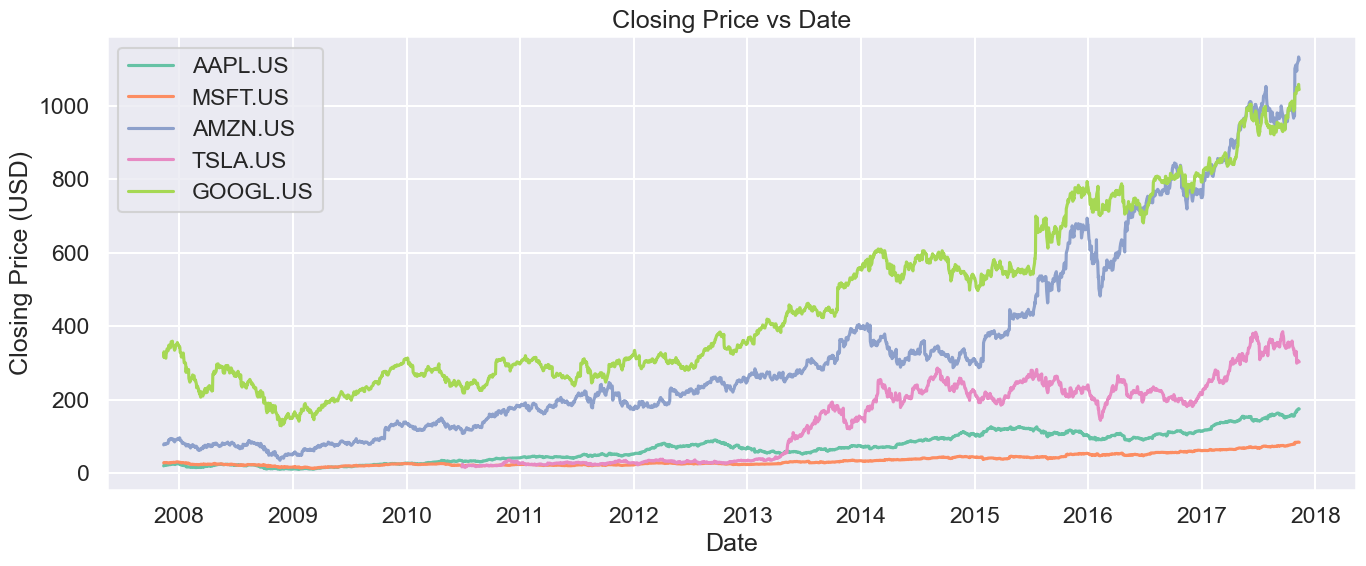

In [15]:
# 1. Closing Price vs Date
plt.figure(figsize=(14, 6))
for ticker in tickers:
    temp = df_plot[df_plot['Ticker'] == ticker]
    plt.plot(temp['Date'], temp['Close'], label=ticker.upper())

plt.title("Closing Price vs Date")
plt.xlabel("Date")
plt.ylabel("Closing Price (USD)")
plt.legend()
plt.tight_layout()
plt.show()

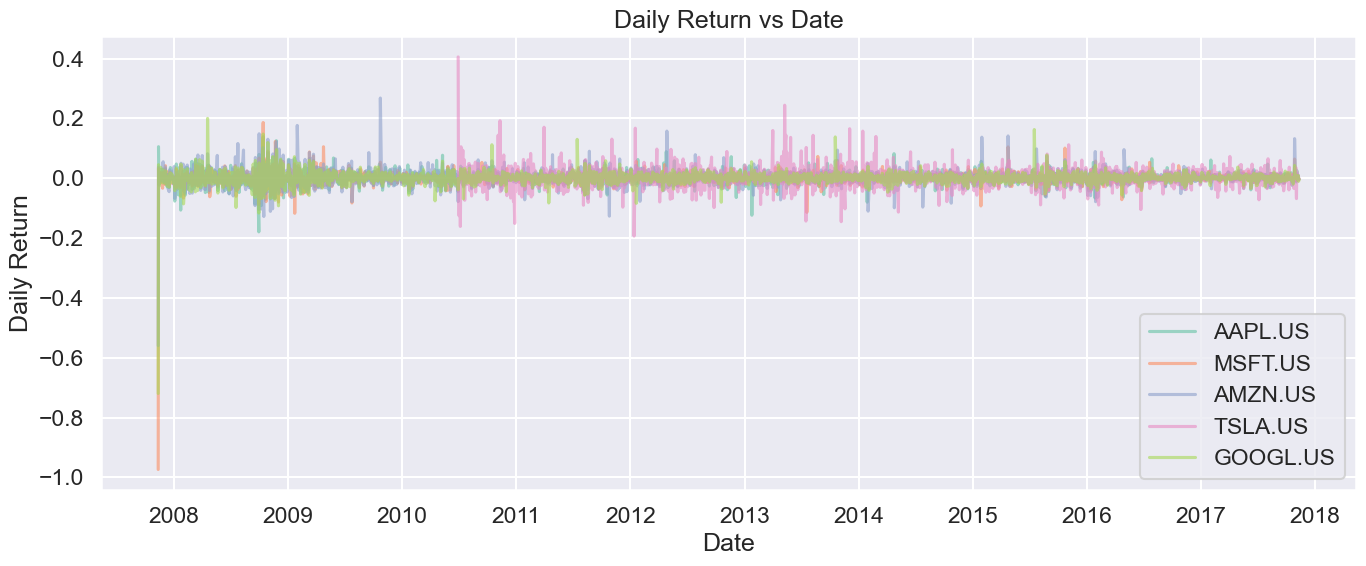

In [16]:
# 2. Daily Return vs Date
plt.figure(figsize=(14, 6))
for ticker in tickers:
    temp = df_plot[df_plot['Ticker'] == ticker]
    plt.plot(temp['Date'], temp['Daily Return'], label=ticker.upper(), alpha=0.6)

plt.title("Daily Return vs Date")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.legend()
plt.tight_layout()
plt.show()

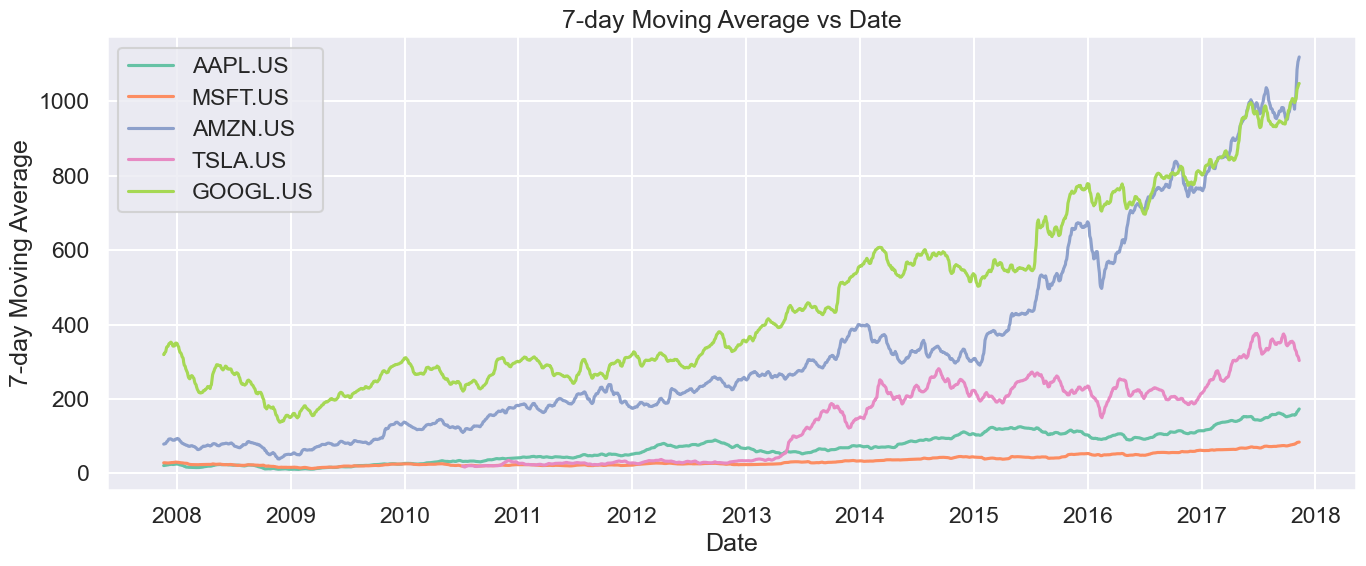

In [17]:
# 3. 7-day Moving Average vs Date
plt.figure(figsize=(14, 6))
for ticker in tickers:
    temp = df_plot[df_plot['Ticker'] == ticker]
    plt.plot(temp['Date'], temp['7-day Moving Average'], label=ticker.upper())

plt.title("7-day Moving Average vs Date")
plt.xlabel("Date")
plt.ylabel("7-day Moving Average")
plt.legend()
plt.tight_layout()
plt.show()

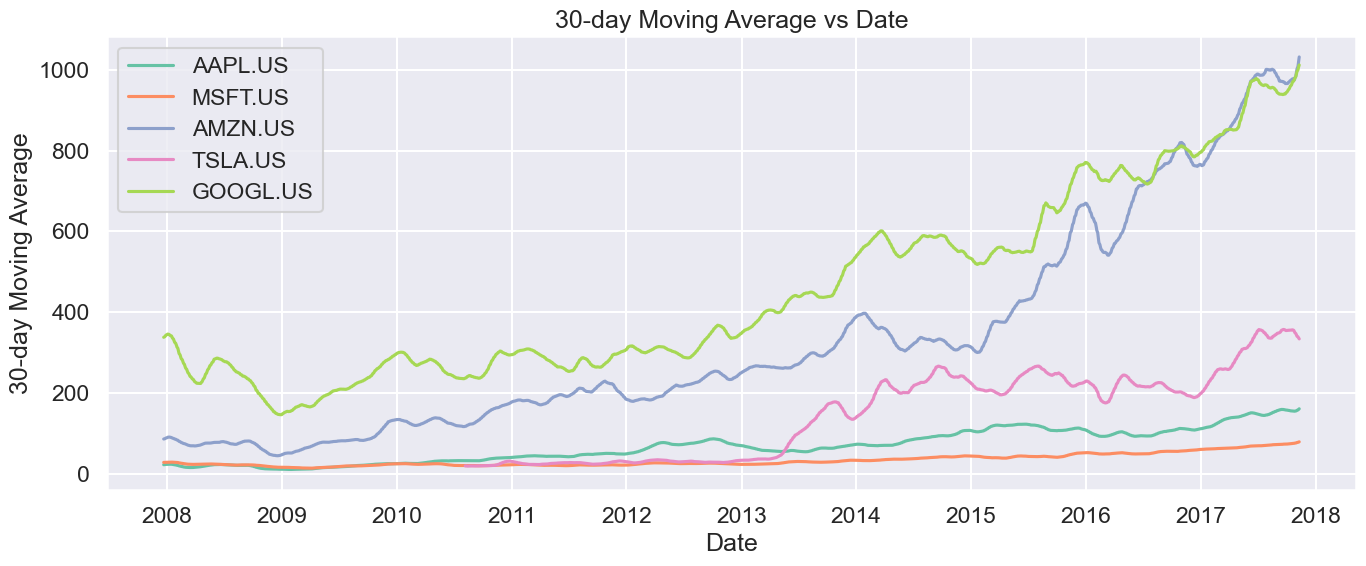

In [18]:
# 4. 30-day Moving Average vs Date
plt.figure(figsize=(14, 6))
for ticker in tickers:
    temp = df_plot[df_plot['Ticker'] == ticker]
    plt.plot(temp['Date'], temp['30-day Moving Average'], label=ticker.upper())

plt.title("30-day Moving Average vs Date")
plt.xlabel("Date")
plt.ylabel("30-day Moving Average")
plt.legend()
plt.tight_layout()
plt.show()

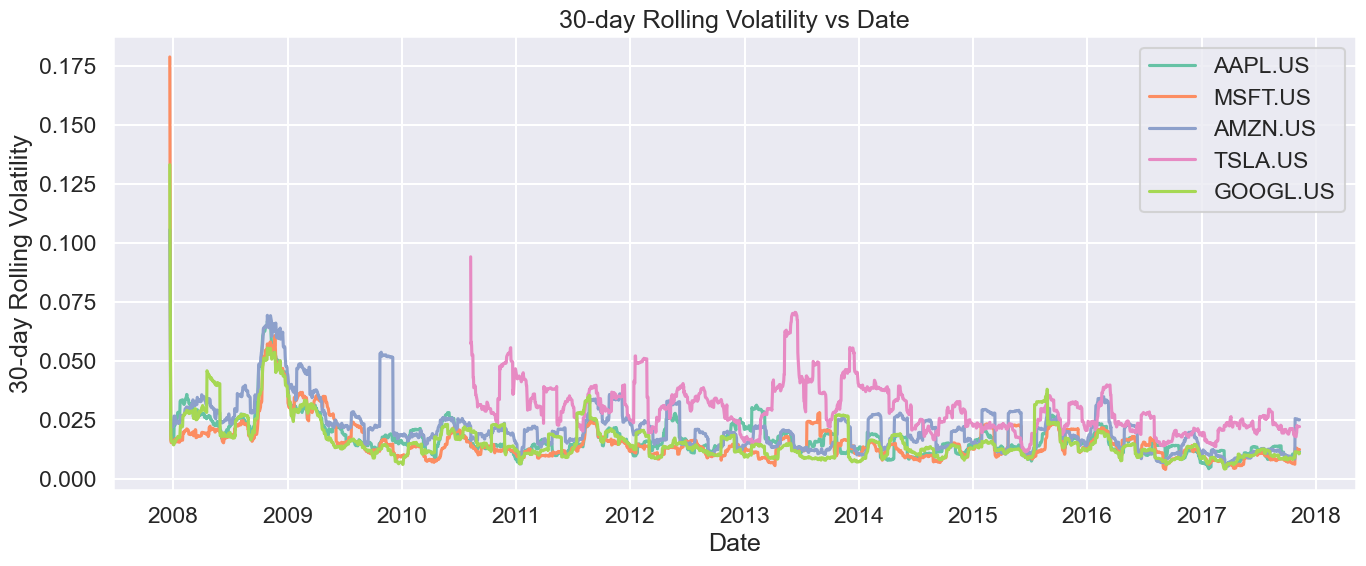

In [19]:
# 5. 30-day Rolling Volatility vs Date
plt.figure(figsize=(14, 6))
for ticker in tickers:
    temp = df_plot[df_plot['Ticker'] == ticker]
    plt.plot(temp['Date'], temp['30-day Rolling Volatility'], label=ticker.upper())

plt.title("30-day Rolling Volatility vs Date")
plt.xlabel("Date")
plt.ylabel("30-day Rolling Volatility")
plt.legend()
plt.tight_layout()
plt.show()

### **EXTRA OBSERVATION**
* ```Microsoft``` has one outlier of a *Rolling Volatility* near the end of $2008$, which is our candidate for the **Most Volatile Month**.
* However, ```Tesla``` overall has shown the highest *Rolling Volatility* for most of the span here, and should be considered the **Most Volatile Overall**.